<a href="https://colab.research.google.com/github/quockhanhdao/Lung_Tumours_Segmentation/blob/main/Lung_Tumours_Segmentation_(custom_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"
!pip install neptune-client torch torchvision

# Import libraries

In [2]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

from typing import Optional, Sequence, Union, Tuple

import monai

from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.factories import Act, Norm
from monai.networks.layers.simplelayers import SkipConnection

from monai.apps import DecathlonDataset
from monai.data import DataLoader, decollate_batch
from monai.utils import first
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    ToTensorD,
    AsDiscrete
)

import torch
from torch import nn
from torch.nn import (
    Conv3d,
    ConvTranspose3d,
    MaxPool3d,
    ModuleList,
    ReLU,
    functional,
    Dropout,
)
from torchvision.transforms import CenterCrop

import math
import numpy as np
import matplotlib.pyplot as plt

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


# Track model (neptune.ai)

In [3]:
import neptune.new as neptune

run = neptune.init(
    project = "khanh.daoquoc/Lung-Tumours-Segmentation",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3Mjg4YTFkMy05ODlmLTQ3OWUtOWJhZS0yYjk5YmJlMmQ2NTMifQ==",
)

https://app.neptune.ai/khanh.daoquoc/Lung-Tumours-Segmentation/e/LUNG-29
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Load data

## Test data

In [4]:
# Dowload data, src: http://medicaldecathlon.com/
dataset = DecathlonDataset(root_dir = "./", 
                           task = "Task06_Lung", section = "training", 
                           transform = None, download = True)
print(f"\nNumber of subjects: {len(dataset)}.\nThe first element in the dataset is {dataset[0]}.")

Task06_Lung.tar: 8.53GB [09:10, 16.7MB/s]                            

2022-09-14 12:03:51,422 - INFO - Downloaded: Task06_Lung.tar


2022-09-14 12:04:34,739 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2022-09-14 12:04:34,741 - INFO - Writing into directory: ..


Loading dataset: 100%|██████████| 51/51 [00:00<00:00, 117018.33it/s]


Number of subjects: 51.
The first element in the dataset is {'image': 'Task06_Lung/imagesTr/lung_014.nii.gz', 'label': 'Task06_Lung/labelsTr/lung_014.nii.gz'}.


In [5]:
# Load data to check
loader = LoadImageD(keys=("image", "label"))
data_check = loader({"image": "Task06_Lung/imagesTr/lung_014.nii.gz",
                     "label": "Task06_Lung/labelsTr/lung_014.nii.gz"})
print(f"Image shape: {data_check['image'].shape} \nLabel shape: {data_check['label'].shape}")

Image shape: (512, 512, 589) 
Label shape: (512, 512, 589)


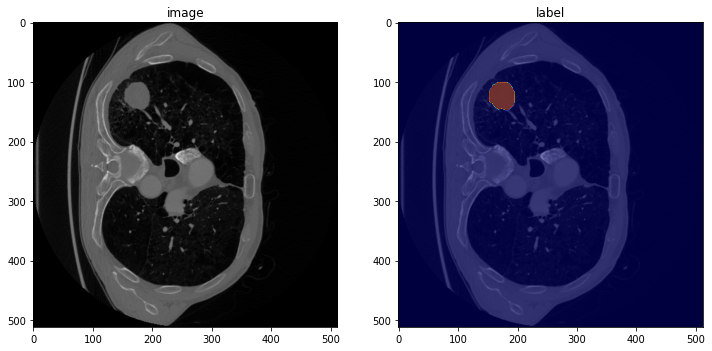

In [6]:
# Visualize check image and label
slide = 379
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")
plt.imshow(data_check['label'][:, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

## Load training set

In [7]:
# Set up transform
KEYS = ["image", "label"]

transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, 
             pixdim = (1., 1., 1.), 
             mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, 
            (128, 128, 64), 
            mode = ('trilinear', 'nearest')),
    RandAffineD(keys = KEYS, 
                spatial_size = (128, 128, 96),
                rotate_range = (0, 0, np.pi/12),
                scale_range = (0.1, 0.1, 0.1),
                mode = ('bilinear', 'nearest'),
                prob = 1.0),
    ToTensorD(KEYS),
])

# Load data
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = transform, download = True)

train_loader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 4)

2022-09-14 12:06:32,044 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2022-09-14 12:06:32,045 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2022-09-14 12:06:32,050 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 51/51 [09:59<00:00, 11.75s/it]


In [8]:
# Check training set
print(f"Length of training set: {len(train_loader)}")

check_training = first(train_loader)
training_image, training_label = check_training['image'], check_training['label']
print(f"check data training image shape: {training_image.shape} \ncheck data training label shape: {training_label.shape}")

Length of training set: 51
check data training image shape: (1, 1, 128, 128, 96) 
check data training label shape: (1, 1, 128, 128, 96)


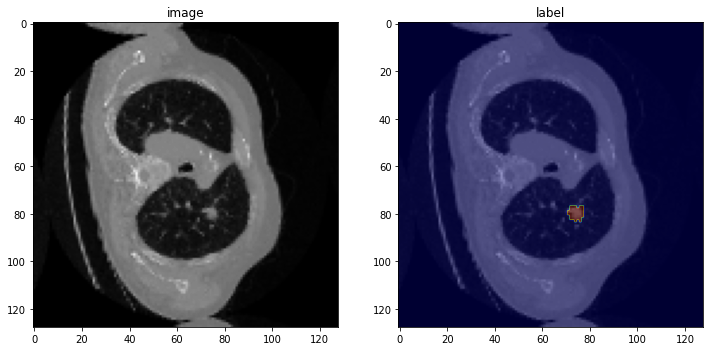

In [9]:
# Visualize training data
slide = 60
plt.figure("Training Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(training_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.4)

plt.show()

## Load validation set

In [10]:
# Set up transform
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, (128, 128, 96), mode = ('trilinear', 'nearest')),
    ToTensorD(KEYS),
])

# Load data
val_dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "validation",
                           transform = val_transform, download = True)

val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 4)

2022-09-14 12:17:22,586 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2022-09-14 12:17:22,591 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2022-09-14 12:17:22,593 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 12/12 [02:22<00:00, 11.91s/it]


In [11]:
# Check validation set
print(f"Length of validation set: {len(val_loader)}")

check_val = first(val_loader)
val_image, val_label = check_val['image'], check_val['label']
print(f"check data image shape: {val_image.shape} \ncheck data label shape: {val_label.shape}")

Length of validation set: 12
check data image shape: (1, 1, 128, 128, 96) 
check data label shape: (1, 1, 128, 128, 96)


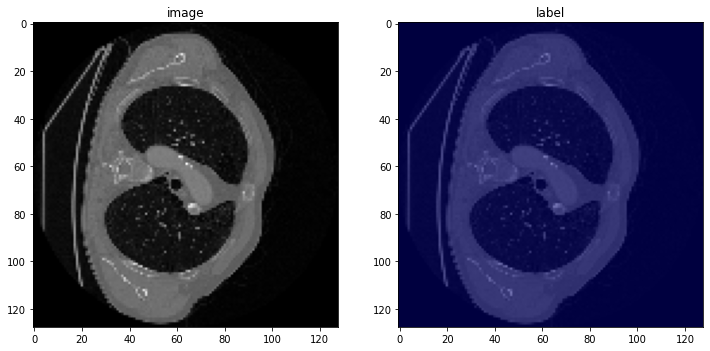

In [12]:
# Visualize validation data
slide = 66
plt.figure("Validation Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(val_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

# Model, Loss, Optimizer

## Construct model

 ### UNet (with ResUnit)

In [13]:
model_version = neptune.init_model_version(
    model="LUNG-RESUNET",
    project="khanh.daoquoc/Lung-Tumours-Segmentation",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3Mjg4YTFkMy05ODlmLTQ3OWUtOWJhZS0yYjk5YmJlMmQ2NTMifQ==", # your credentials
)

https://app.neptune.ai/khanh.daoquoc/Lung-Tumours-Segmentation/m/LUNG-RESUNET/v/LUNG-RESUNET-1
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/model-version#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [14]:
class UNet(nn.Module):
  def __init__(self,
      in_channels: int,
      out_channels: int,
      channels: Sequence[int],
      num_res_units: int,
      act: Union[Tuple, str] = Act.PRELU,
      norm: Union[Tuple, str] = Norm.INSTANCE,
      dropout: float = 0.0,
  ) -> None:
    
    super().__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.channels = channels
    self.num_res_units = num_res_units
    self.act = act
    self.norm = norm
    self.dropout = dropout

    def block(
        inc: int, outc: int, channels: Sequence[int], is_top: bool
    ) -> nn.Module:
    # 16, 32, 64, 128
      c = channels[0]

      subblock: nn.Module

      if len(channels) > 2:
        subblock = block(c, c, channels[1:], False)
        upc = c * 2
      else:
        subblock = self.bottom_layer(c, channels[1])
        upc = c + channels[1]

      down = self.down_layer(inc, c, 2, is_top)
      up = self.up_layer(upc, outc, 2, is_top)

      return self.connection_block(down, up, subblock)
    
    self.model = block(in_channels, out_channels, self.channels, True)

  def connection_block(
      self, down_path: nn.Module, up_path: nn.Module, subblock: nn.Module
  ) -> nn.Module:
    return nn.Sequential(down_path, SkipConnection(subblock), up_path)

  def down_layer(
      self, in_channels: int, out_channels: int, strides: int, is_top: bool
  ) -> nn.Module:
    mod: nn.Module
    if self.num_res_units > 0:
      mod = ResidualUnit(
          spatial_dims = 3,
          in_channels = in_channels,
          out_channels = out_channels,
          strides = strides,
          kernel_size = 3,
          subunits = self.num_res_units,
          act = self.act,
          norm = self.norm,
          dropout = self.dropout,
      )
      return mod
    mod = Convolution(
        spatial_dims = 3,
        in_channels = in_channels,
        out_channels = out_channels,
        strides = strides,
        kernel_size = 3,
        act = self.act,
        norm = self.norm,
        dropout = self.dropout,
    )
    return mod

  def bottom_layer(
      self, in_channels: int, out_channels: int
  ) -> nn.Module:
    return self.down_layer(in_channels, out_channels, 1, False)

  def up_layer(
      self, in_channels: int, out_channels: int, strides: int, is_top: bool
  ) -> nn.Module:
    conv: Union[Convolution, nn.Sequential]

    conv = Convolution(
        spatial_dims = 3,
        in_channels = in_channels,
        out_channels = out_channels,
        strides = strides,
        kernel_size = 3,
        act = self.act,
        norm = self.norm,
        dropout = self.dropout,
        conv_only = is_top and self.num_res_units == 0,
        is_transposed = True,
    )

    if self.num_res_units > 0:
      res = ResidualUnit(
          spatial_dims = 3, 
          in_channels = out_channels,
          out_channels = out_channels,
          strides = 1,
          kernel_size = 3,
          subunits = 1,
          act = self.act,
          norm = self.norm,
          dropout = self.dropout,
          last_conv_only = is_top,
      )
      conv = nn.Sequential(conv, res)
    
    return conv
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.model(x)
    return x

### SwinUNet

In [ ]:
model_version = neptune.init_model_version(
    model="LUNG-SWINUNET",
    project="khanh.daoquoc/Lung-Tumours-Segmentation",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3Mjg4YTFkMy05ODlmLTQ3OWUtOWJhZS0yYjk5YmJlMmQ2NTMifQ==", # your credentials
)

## Configuration

In [15]:
config = {
    'in_channels' : 1,
    'out_channels' : 2,
    'channels' : (128, 256, 512, 1024),
    'drop_out' : 0.5,
    'num_res_units' : 2,
    'norm' : Norm.BATCH,

    'learning_rate' : 0.001,
    'decay_lr' : True,
    'decay_rate' : 0.5,
    'decay_step' : 50,

    'epoch' : 100,
    'val_interval' : 1
}

run["parameters"] = config
model_version["parameters"] = config

## Setup model

In [18]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

model = UNet(
    in_channels = config['in_channels'],
    out_channels = config['out_channels'],
    channels = config['channels'],
    num_res_units = config['num_res_units'],
    norm = config['norm'],
    dropout = config['drop_out'],
).to(device)

# print(model)

loss_function = monai.losses.DiceLoss(include_background = False, to_onehot_y = True, softmax = True) # using Dice Loss function
optimizer = torch.optim.Adam(model.parameters(), lr = config['learning_rate'])
dice_metric = monai.metrics.DiceMetric(include_background = False, reduction = "mean")
if config['decay_lr']:
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = config['decay_step'])

# Start training

In [ ]:
loss_values = []
metric_values = []
best_metric = -1
best_metric_epoch = -1
post_pred = Compose([AsDiscrete(argmax = True, to_onehot = 2)])
post_label = Compose([AsDiscrete(to_onehot = 2)])

print("Start training the network...")

for epoch in range(config['epoch']):
  print("-" * 13)
  print(f"Epoch {epoch + 1}/{config['epoch']}")

  # Turn model to "train" mode
  model.train()

  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1

    input, label = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )

    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, label)
    loss.backward() # Compute gradient
    optimizer.step() # Update model's parameters

    epoch_loss += loss.item()
    print(f"{step}/{len(dataset) // train_loader.batch_size}, "
          f"train_loss: {loss.item():4f}")
    
  epoch_loss /= step
  loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  # Track train loss
  run["train/loss"].log(epoch_loss)
  model_version["train/loss"].log(epoch_loss)

  # Decay learning rate if decay_lr = True
  if config['decay_lr']:
    scheduler.step()

  if (epoch + 1) % config['val_interval'] == 0:
    # Turn model to "eval" mode
    model.eval()

    with torch.no_grad():
      metric = 0
      step_val = 0
      for val_data in val_loader:
        step_val += 1

        val_input, val_label = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        
        """
        val_output = model(val_input)
        val_output = torch.round(val_output)
        curr_metric = dice_metric(val_output, val_label)
        metric += curr_metric.item()
        """

        roi_size = (128, 128, 96)
        sw_batch_size = 1

        val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
        val_output = [post_pred(i) for i in decollate_batch(val_output)]
        val_label = [post_label(i) for i in decollate_batch(val_label)]

        # Compute metric for current iteration
        dice_metric(y_pred = val_output, y = val_label)

      """
      metric /= step_val
      """

      # Aggregate the final mean dice result
      metric = dice_metric.aggregate().item()

      # Reset the status for the next epoch
      dice_metric.reset()

      metric_values.append(metric)
      
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        print("Saved new best metric model!!!")
        torch.save(model.state_dict(), "best_metric_model.pth")

      print(
          f"current epoch: {epoch + 1},"
          f" current mean dice: {metric:.4f},"
          f" best mean dice: {best_metric:.4f},"
          f" at epoch: {best_metric_epoch}"
      )

      # Track train dice metric
      run["train/dice"].log(metric)
      model_version["train/dice"].log(metric)

print(
    f"train completed, best metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)

In [20]:
# Track best dice metric and stop 'run'
run["best dice"] = best_metric
model_version["best dice"] = best_metric
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/khanh.daoquoc/Lung-Tumours-Segmentation/e/LUNG-29


# Check model

In [ ]:
checker = first(val_loader)
image, label = checker['image'], checker['label']

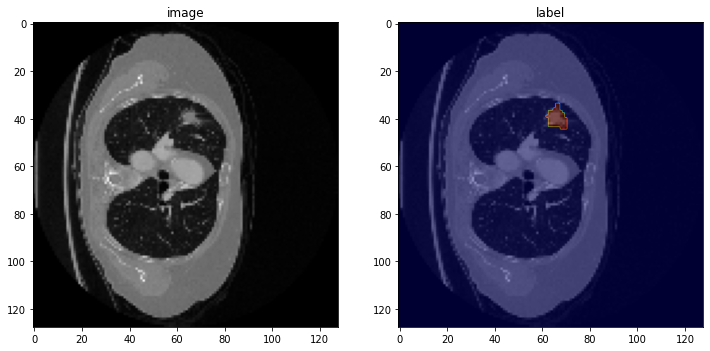

In [ ]:
# Visualize training data
slide = 64
plt.figure("Training Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.4)

plt.show()

Output shape: (1, 1, 128, 128, 96)


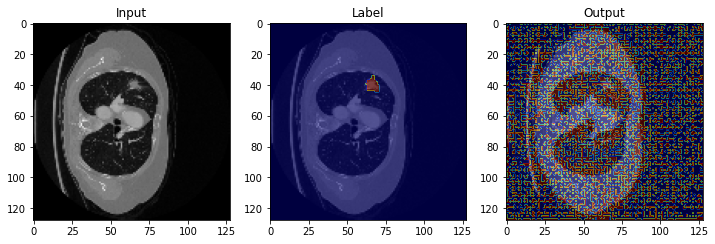

In [ ]:
model.cpu()
model.load_state_dict(torch.load("best_metric_model.pth"))

with torch.no_grad():
  output = model(image)
  output = torch.nn.Sigmoid()(output)
  output = torch.round(output)
  print(f"Output shape: {output.shape}")

  slide = 64
  plt.figure("Test Model", (12, 12))

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

  plt.subplot(1, 3, 2)
  plt.title("Label")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.subplot(1, 3, 3)
  plt.title("Output")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(output[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.show()